# Predicting projects that are unlikely to be funded without expert assistance to prioritize resources for DonorsChoose

### Arthur Spirou (aspirou), Akin Joseph (ababujos), & Nikki Chen (yiqichen)
Machine Learning Foundations with Python
May 1, 2025

### Import Required Libraries

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

In [5]:
#from google.colab import drive

In [7]:
#drive.mount('/content/drive')

In [9]:
#df = pd.read_csv('/content/drive/My Drive/ML Project/Nikki/TIDY_unclean.csv')

In [2]:
warnings.filterwarnings('ignore')

### Create a 70%/30% Biased Coin Classifier for use as a baseline model

In [98]:
class BiasedCoinClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, random_state=42):
        self.random_state = random_state

    def fit(self, X, y):
        return self

    def predict(self, X):
        rng = np.random.RandomState(self.random_state)
        return rng.choice([0, 1], size=X.shape[0], p=[0.7, 0.3])

    def predict_proba(self, X):
        return np.tile([0.7, 0.3], (X.shape[0], 1))

In [11]:
df = pd.read_csv('TIDY.csv')

In [12]:
data = df.copy()

In [15]:
# Uncomment this to see the full list of columns
#print(df.columns.tolist())

### Remove the year 2014 as we do not have labels for these projects, then select desired features to include

In [18]:
df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce')

# Filter out any rows posted in 2014 or later
df = df[df['date_posted'] < pd.Timestamp('2014-01-01')]

# Define columns to keep
selected_columns = [
    'school_state',  # renamed as 'state'
    'school_charter',
    'total_price_including_optional_support',
    'total_price_excluding_optional_support',
    'primary_focus_subject',
    'resource_type',
    'poverty_level',
    'grade_level',
    'eligible_double_your_impact_match',
    'eligible_almost_home_match',
    'fully_funded',           # label (will rename to is_fully_funded)
    'projectid',              # keep for reference (not ML input)
    'date_posted',             # keep for date-based split (not ML input)
    'sp500_avg_30d',
    'sp500_std_30d'
]

df_filtered = df[selected_columns]

print(f"Filtered data shape: {df_filtered.shape}")
df_filtered.head()

Filtered data shape: (619326, 15)


,school_state,school_charter,total_price_including_optional_support,total_price_excluding_optional_support,primary_focus_subject,resource_type,poverty_level,grade_level,eligible_double_your_impact_match,eligible_almost_home_match,fully_funded,projectid,date_posted,sp500_avg_30d,sp500_std_30d
0,NY,f,279.27,229.0,Other,Supplies,highest poverty,Grades 6-8,f,f,t,77558a6eda151deee9a00553f7fccfc7,2002-09-13,907.823004,30.096573
1,NY,f,152.44,125.0,Literacy,Books,highest poverty,Grades 9-12,f,f,t,e139df754a873a62d93daa56acbf8040,2002-09-13,907.823004,30.096573
2,NY,f,152.44,125.0,Early Development,Supplies,moderate poverty,Grades 3-5,f,f,t,82e536f14eadf2671a70e03416f695a3,2002-09-16,908.718337,29.139639
3,NY,f,998.78,819.0,Other,Supplies,highest poverty,Grades 3-5,f,f,t,8a8411fa1c3bc55c1481978c5e2e6386,2002-09-17,910.015672,26.470111
4,NY,f,1376.83,1129.0,Economics,Technology,highest poverty,Grades 9-12,f,f,t,e02da37beb332eb66c2d2ba989c597ad,2002-09-17,910.015672,26.470111


### Missing Values/Outliers Check
Note: Some previous cleaning has already been done on this data but not on all possible features

In [21]:
# Columns to check for outliers
price_cols = [
    'total_price_including_optional_support',
    'total_price_excluding_optional_support'
]

# NaN summary
nan_summary = df_filtered.isna().sum().to_frame(name='missing_count')
nan_summary['missing_pct'] = (nan_summary['missing_count'] / len(df_filtered)) * 100

# Outlier summary for the two price columns
outlier_summary = pd.DataFrame(columns=['lower_bound', 'upper_bound', 'outlier_count', 'outlier_pct'])

for col in price_cols:
    lower = df_filtered[col].quantile(0.01)
    upper = df_filtered[col].quantile(0.99)
    outlier_mask = (df_filtered[col] < lower) | (df_filtered[col] > upper)
    outlier_count = outlier_mask.sum()
    outlier_pct = outlier_count / len(df_filtered) * 100

    outlier_summary.loc[col] = [lower, upper, outlier_count, outlier_pct]

# Combine both summaries
summary_report = nan_summary.copy()
summary_report[['lower_bound', 'upper_bound', 'outlier_count', 'outlier_pct']] = outlier_summary

# Show full report
summary_report.fillna('', inplace=True)
summary_report

,missing_count,missing_pct,lower_bound,upper_bound,outlier_count,outlier_pct
school_state,0,0.000000,,,,
school_charter,0,0.000000,,,,
total_price_including_optional_support,0,0.000000,147.56,2822.635,12344.0,1.993134
total_price_excluding_optional_support,0,0.000000,121.0,2366.7175,12325.0,1.990067
primary_focus_subject,36,0.005813,,,,
resource_type,43,0.006943,,,,
poverty_level,0,0.000000,,,,
grade_level,7,0.001130,,,,
eligible_double_your_impact_match,0,0.000000,,,,
eligible_almost_home_match,0,0.000000,,,,


In [23]:
# Drop Missing Value and Outlier Rows since they are a small percentage of the total data

print('Shape BEFORE dropping missing values/outliers: ', df_filtered.shape)
df_cleaned = df_filtered.dropna()
df_cleaned = df_cleaned[(df_cleaned[col] >=  lower) & (df_cleaned[col] <= upper)]
print('Shape AFTER dropping missing values/outliers: ', df_cleaned.shape)

# Convert t/f → 1/0 for standard binary columns
binary_cols = [
    'school_charter',
    'eligible_double_your_impact_match',
    'eligible_almost_home_match'
]

for col in binary_cols:
    df_cleaned[col] = df_cleaned[col].map({'t': 1, 'f': 0})

# Convert t/f → 0/1 for the label (fully_funded: 't' means funded → now label 0)
df_cleaned['fully_funded'] = df_cleaned['fully_funded'].map({'t': 0, 'f': 1})

df_cleaned.head()

Shape BEFORE dropping missing values/outliers:  (619326, 15)
Shape AFTER dropping missing values/outliers:  (606954, 15)


,school_state,school_charter,total_price_including_optional_support,total_price_excluding_optional_support,primary_focus_subject,resource_type,poverty_level,grade_level,eligible_double_your_impact_match,eligible_almost_home_match,fully_funded,projectid,date_posted,sp500_avg_30d,sp500_std_30d
0,NY,0,279.27,229.0,Other,Supplies,highest poverty,Grades 6-8,0,0,0,77558a6eda151deee9a00553f7fccfc7,2002-09-13,907.823004,30.096573
1,NY,0,152.44,125.0,Literacy,Books,highest poverty,Grades 9-12,0,0,0,e139df754a873a62d93daa56acbf8040,2002-09-13,907.823004,30.096573
2,NY,0,152.44,125.0,Early Development,Supplies,moderate poverty,Grades 3-5,0,0,0,82e536f14eadf2671a70e03416f695a3,2002-09-16,908.718337,29.139639
3,NY,0,998.78,819.0,Other,Supplies,highest poverty,Grades 3-5,0,0,0,8a8411fa1c3bc55c1481978c5e2e6386,2002-09-17,910.015672,26.470111
4,NY,0,1376.83,1129.0,Economics,Technology,highest poverty,Grades 9-12,0,0,0,e02da37beb332eb66c2d2ba989c597ad,2002-09-17,910.015672,26.470111


### Grab Previous Year's State GDP feature from CSV

In [26]:
#df_gdp = pd.read_csv('/content/drive/My Drive/ML Project/Nikki/SASUMMARY__ALL_AREAS_1998_2024.csv')
df_gdp = pd.read_csv('SASUMMARY__ALL_AREAS_1998_2024.csv')
df_gdp_filtered = df_gdp[df_gdp['Description'] == ' Gross domestic product (GDP) ']

df_gdp_filtered = df_gdp_filtered.drop(['GeoFIPS', 'Region', 'TableName', 'LineCode', 'IndustryClassification'], axis=1)
df_gdp_filtered = df_gdp_filtered.drop(3, axis=0)
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "Virgin Islands, U.S.": "VI",
}
df_gdp_filtered['GeoName'] = df_gdp_filtered['GeoName'].replace(us_state_to_abbrev)

df_gdp_filtered.head()

,GeoName,Description,Unit,1998,1999,2000,2001,2002,2003,2004,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
18,AL,Gross domestic product (GDP),Millions of current dollars,110838.8,116514.3,120522.6,123534.5,128380.9,135212.6,148379.1,...,203113.3,208824.3,216615.5,226263.8,234798.2,235325.3,260018.4,284949.1,304935.6,321237.6
33,AK,Gross domestic product (GDP),Millions of current dollars,24387.8,24920.4,26934,28660.9,29884.5,32115.8,35389.5,...,51574.2,51121.8,53550.9,54762,54549.6,51283.4,58943.5,66271.9,68056,69969
48,AZ,Gross domestic product (GDP),Millions of current dollars,144393.2,156442.1,165735.6,172899.6,180844.5,194318,207246.3,...,298942.2,313787.1,333099,353671,375376.7,388956.7,436778.6,484052.2,522767.2,552167
63,AR,Gross domestic product (GDP),Millions of current dollars,62852,67279,69176.3,71099.6,74453.1,79009.7,85928.6,...,118573.6,120987.4,123882.6,129213.8,132625.8,136198.4,154052.5,168605.8,178606.4,188723.1
78,CA,Gross domestic product (GDP),Millions of current dollars,1143672.5,1239773.5,1354791.3,1373270.8,1419321.8,1498578,1585081.4,...,2487156.4,2586485.2,2740550.3,2899530.9,3068629.7,3076755.1,3423958.3,3660415.7,3870378.9,4103123.6


In [28]:
# Extract the year from the date_posted column
df_cleaned['year_posted'] = df_cleaned['date_posted'].dt.year

# Melt the GDP dataframe so years become rows
df_gdp_melted = df_gdp_filtered.melt(
    id_vars=['GeoName'],
    value_vars=[str(year) for year in range(2002, 2014)],
    var_name='gdp_year',
    value_name='state_gdp'
)

# Convert gdp_year to numeric
df_gdp_melted['gdp_year'] = df_gdp_melted['gdp_year'].astype(int)

# Rename 'GeoName' to match merge key
df_gdp_melted.rename(columns={'GeoName': 'school_state'}, inplace=True)

# merge using year_posted - 1 to get **previous year's GDP**
df_cleaned['prev_year'] = df_cleaned['year_posted'] - 1

df_merged = df_cleaned.merge(
    df_gdp_melted,
    how='left',
    left_on=['school_state', 'prev_year'],
    right_on=['school_state', 'gdp_year']
)

# Drop unused columns
df_merged = df_merged.drop(columns=['gdp_year', 'prev_year'])
df_merged.head()

,school_state,school_charter,total_price_including_optional_support,total_price_excluding_optional_support,primary_focus_subject,resource_type,poverty_level,grade_level,eligible_double_your_impact_match,eligible_almost_home_match,fully_funded,projectid,date_posted,sp500_avg_30d,sp500_std_30d,year_posted,state_gdp
0,NY,0,279.27,229.0,Other,Supplies,highest poverty,Grades 6-8,0,0,0,77558a6eda151deee9a00553f7fccfc7,2002-09-13,907.823004,30.096573,2002,NaN
1,NY,0,152.44,125.0,Literacy,Books,highest poverty,Grades 9-12,0,0,0,e139df754a873a62d93daa56acbf8040,2002-09-13,907.823004,30.096573,2002,NaN
2,NY,0,152.44,125.0,Early Development,Supplies,moderate poverty,Grades 3-5,0,0,0,82e536f14eadf2671a70e03416f695a3,2002-09-16,908.718337,29.139639,2002,NaN
3,NY,0,998.78,819.0,Other,Supplies,highest poverty,Grades 3-5,0,0,0,8a8411fa1c3bc55c1481978c5e2e6386,2002-09-17,910.015672,26.470111,2002,NaN
4,NY,0,1376.83,1129.0,Economics,Technology,highest poverty,Grades 9-12,0,0,0,e02da37beb332eb66c2d2ba989c597ad,2002-09-17,910.015672,26.470111,2002,NaN


In [30]:
# Sanity check on the start and end dates of the data prior to proceeding with train/test splits
print(df_merged['date_posted'].min(), '\n', df_merged['date_posted'].max())

2002-09-13 00:00:00 
 2013-12-31 00:00:00


### Create Masks and Conduct earliest 80%/latest 20% Train/Test Split based on data sorted by project posting date

In [33]:
# Ensure datetime format
df_merged['date_posted'] = pd.to_datetime(df_merged['date_posted'], errors='coerce')

# Sort by time
df_sorted = df_merged.sort_values('date_posted')

# Get 80% split index
split_index = int(0.8 * len(df_sorted))

# Get the cutoff date at that index
cutoff_date = df_sorted.iloc[split_index]['date_posted']

# Create masks using cutoff_date
train_mask = df_merged['date_posted'] < cutoff_date
test_mask = ~train_mask

print("Cutoff date for 80/20 split:", cutoff_date)

# Set up feature and target columns
df_model = df_merged.copy()
target_col = 'fully_funded'

columns_to_drop = ['projectid', 'date_posted', 'fully_funded']
feature_cols = [col for col in df_model.columns if col not in columns_to_drop]

# Apply masks to split data
X_train = df_model.loc[train_mask, feature_cols]
y_train = df_model.loc[train_mask, target_col]

X_test = df_model.loc[test_mask, feature_cols]
y_test = df_model.loc[test_mask, target_col]

# Output info
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Target distribution in train:\n{y_train.value_counts(normalize=True)}")

Cutoff date for 80/20 split: 2013-02-02 00:00:00
Train shape: (485445, 14), Test shape: (121509, 14)
Target distribution in train:
fully_funded
0    0.693467
1    0.306533
Name: proportion, dtype: float64


### Create Column Transformer for automated feature encoding

In [36]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

#separate out any ordinal features for ordinal encoding rather than one-hot encoding for the other categorical columns
ordinal_features = ['poverty_level']
categorical_features = [col for col in categorical_features if col not in ordinal_features]

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('ord', OrdinalEncoder(), ordinal_features)
])

### Establish variables for Time-Series Sliding-Window Cross-Validation (n_splits = 5)

In [39]:
# Set up time-aware cross-validation
n=5
tscv = TimeSeriesSplit(n_splits=n)

cv_metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

### Create Dictionary of Models and Grids for Grid Search. Evaluate and select best hyperparameters based upon Precision score

Here we define Logistic Regression, Random Forest, XGBoost, and AdaBoost models with respective hyperparameters

In [43]:
models_and_grids = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "param_grid": {
            "model__C": [0.01, 0.1, 1, 10],
            "model__penalty": ["l2"],
            "model__solver": ["lbfgs"],
            "model__class_weight": ["balanced"]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, n_jobs=-1),
        "param_grid": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [5, 8, 12],
            "model__min_samples_split": [50, 100],
            "model__min_samples_leaf": [20, 50],
            "model__max_features": ["sqrt"]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "param_grid": {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.05, 0.1, 0.3],
            "model__max_depth": [3, 5, 7],
            "model__subsample": [0.8, 1.0],
            "model__colsample_bytree": [0.8, 1.0]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "param_grid": {
            "model__n_estimators": [50, 100, 200],
            "model__learning_rate": [0.1, 0.5, 1.0],
            "model__estimator": [
                DecisionTreeClassifier(max_depth=1),
                DecisionTreeClassifier(max_depth=2)
            ]
        }
    }
}

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Run grid search for each model
for name, config in models_and_grids.items():
    print(f"\nRunning Grid Search for: {name}")

    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('model', config['model'])
    ])

    grid = GridSearchCV(
        pipe,
        param_grid=config['param_grid'],
        cv=tscv,
        scoring=scoring,
        refit='precision',
        n_jobs=-1,
        return_train_score=True
    )

    grid.fit(X_train, y_train)

    print(f"Best precision parameters for {name}: {grid.best_params_}")
    print(f"Best CV Precision Score: {grid.best_score_:.4f}")


Running Grid Search for: Logistic Regression
Best precision parameters for Logistic Regression: {'model__C': 0.01, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV Precision Score: 0.4084

Running Grid Search for: Random Forest
Best precision parameters for Random Forest: {'model__max_depth': 8, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 20, 'model__min_samples_split': 100, 'model__n_estimators': 200}
Best CV Precision Score: 0.7011

Running Grid Search for: XGBoost
Best precision parameters for XGBoost: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.8}
Best CV Precision Score: 0.5199

Running Grid Search for: AdaBoost


KeyboardInterrupt: 

### Plug Optimal Hyperparameters from Grid Search into final models. Then run cross validation and/or test on final holdout set and report metrics

In [100]:
# Run the gridsearch block above this one first to get the best hyperparameters for each model then plug in and cross-validate
models = {
    "Logistic Regression": LogisticRegression(C=0.01, class_weight='balanced', penalty='l2', solver='lbfgs', random_state=42),
    "Random Forest": RandomForestClassifier(max_depth=8, max_features='sqrt', min_samples_leaf=50, min_samples_split=50,
                                            n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0, random_state=42),
    "AdaBoost": AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.1, n_estimators=50, random_state=42),
    "Flip a Coin": DummyClassifier(strategy='uniform', random_state=42),
    "Biased Coin (70/30)": BiasedCoinClassifier(random_state=42)
}

# Dictionary to collect test set metrics per model
results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC': [],
    'Precision@Top10%': [],
    'num_Projects_flagged_for_review': [],
    'fraction_Projects_flagged_for_review': [],
    'TP': [],
    'FP': [],
    'FN': [],
    'TN': []
}

for name, model in models.items():
    print('Cross-Validation Results for ', n, ' splits\n')
    print(f"\nTraining and Cross-validating: {name}")

    # Build the pipeline
    clf = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])

    # --- Time-aware cross-validation on training set ---
    cv_results = cross_validate(clf, X_train, y_train, cv=tscv, scoring=cv_metrics)
    print("Mean scores:")
    for metric in cv_metrics:
        print(f"{metric}: {cv_results[f'test_{metric}'].mean():.4f}")

    # --- Final test set evaluation ---
    # After cross validating on best sets of hyperparameters, comment out the other models in the set above and re-run this cell block
    #                    -to evaluate the best chosen model from grid search + cross-validation.
    # Prior to rerunning this cell block for final evaluation, uncomment the below lines to conduct the final test on the holdout set then proceed to threshold blocks below
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    print(f"{name} - Holdout Test Set Classification Report:\n{classification_report(y_test, y_pred)}")

    # Evaluate metrics
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print('tn:', tn, '\n', 'fp:', fp, '\n', 'fn:', fn, '\n', 'tp:', tp)
    print('\n')

    # Precision@Top10% evaluation on test set
    cutoff = np.percentile(y_proba, 90)
    top_10_mask = y_proba > cutoff
    precision_at_10pct = y_test[top_10_mask].mean()

    print(f"Precision@Top10% on Test Set for {name}: {precision_at_10pct:.4f}")
    print(f"Projects flagged for expert review: {top_10_mask.sum()} of {len(y_test)}")
    print('\n', '\n')

    # Store metrics in the results dictionary
    results['Model'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['Recall'].append(recall_score(y_test, y_pred))
    results['F1 Score'].append(f1_score(y_test, y_pred))
    results['ROC AUC'].append(roc_auc_score(y_test, y_proba))
    results['Precision@Top10%'].append(precision_at_10pct)
    results['num_Projects_flagged_for_review'].append(top_10_mask.sum())
    results['fraction_Projects_flagged_for_review'].append(top_10_mask.sum()/len(y_test))
    results['TP'].append(tp)
    results['FP'].append(fp)
    results['FN'].append(fn)
    results['TN'].append(tn)

# Create a DataFrame of results
results_df = pd.DataFrame(results)

# Set Model column as index
results_df.set_index('Model', inplace=True)

Cross-Validation Results for  5  splits


Training and Cross-validating: Logistic Regression
Mean scores:
accuracy: 0.6152
precision: 0.4084
recall: 0.6054
f1: 0.4807
roc_auc: 0.6460
Logistic Regression - Holdout Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.57      0.67     85781
           1       0.40      0.69      0.51     35728

    accuracy                           0.60    121509
   macro avg       0.61      0.63      0.59    121509
weighted avg       0.69      0.60      0.62    121509

Accuracy: 0.602556189253471
Precision: 0.3987656907136757
Recall: 0.6926500223914017
F1 Score: 0.5061408980743861
ROC AUC Score: 0.6702877896335679
tn: 48469 
 fp: 37312 
 fn: 10981 
 tp: 24747


Precision@Top10% on Test Set for Logistic Regression: 0.4787
Projects flagged for expert review: 12151 of 121509

 

Cross-Validation Results for  5  splits


Training and Cross-validating: Random Forest
Mean scores:
accuracy: 0.705

### Visualize Model Results on Holdout Test Set

### Grouped Bar Plot of Main Metrics

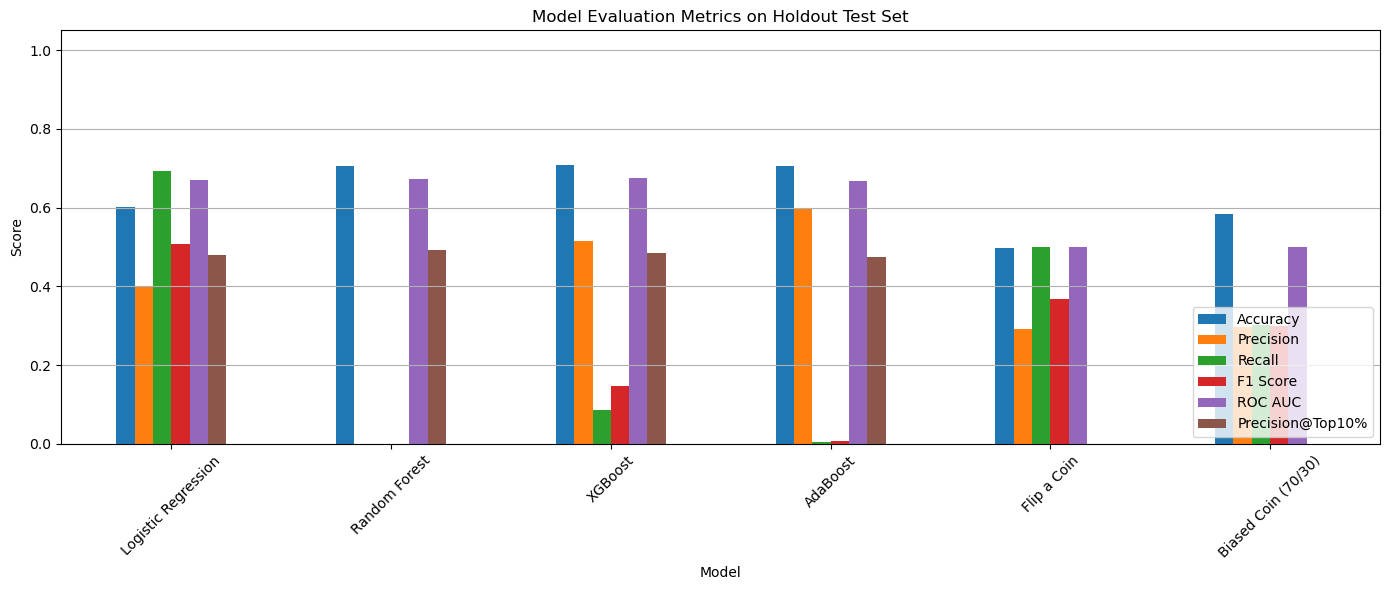

In [102]:
main_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Precision@Top10%']

results_df[main_metrics].plot(kind='bar', figsize=(14, 6), rot=45)
plt.title("Model Evaluation Metrics on Holdout Test Set")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### TP, FP, FN, TN Breakdown

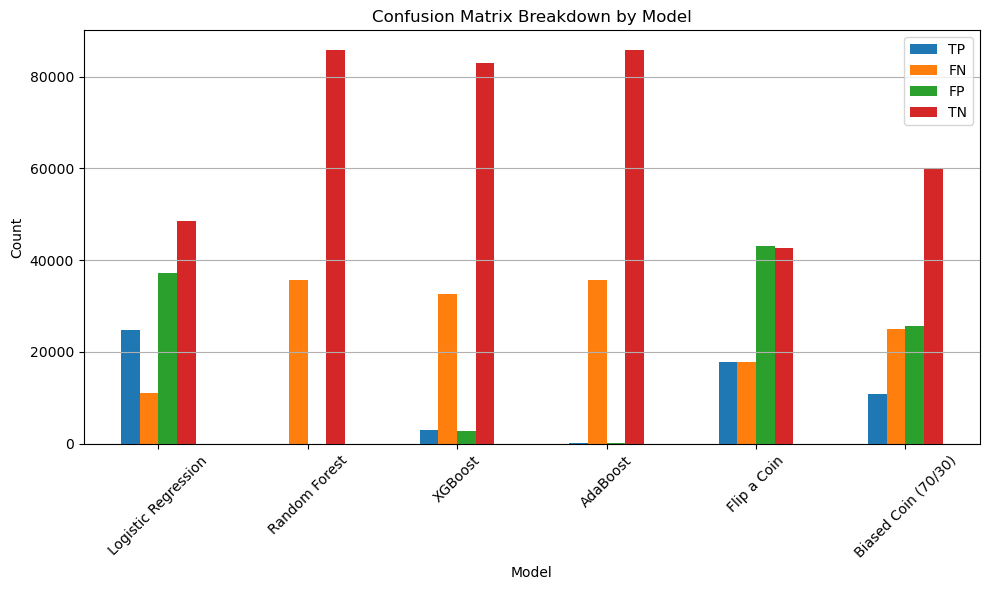

In [109]:
results_df[['TP', 'FN', 'FP', 'TN']].plot(kind='bar', figsize=(10, 6), rot=45)
plt.title("Confusion Matrix Breakdown by Model")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Projects Flagged for Expert Review

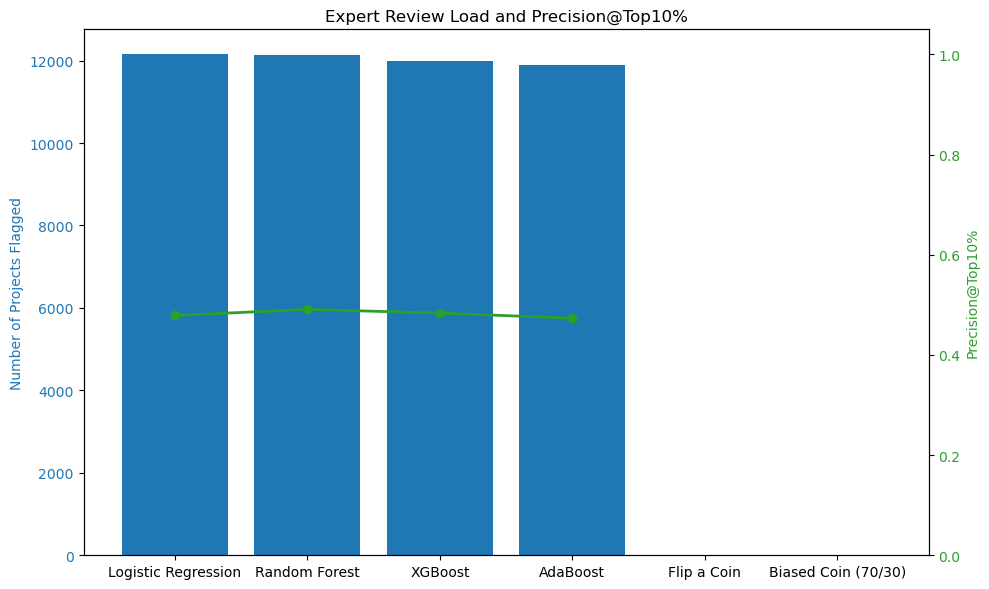

In [112]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'tab:blue'
color2 = 'tab:green'

ax1.set_title("Expert Review Load and Precision@Top10%")
ax1.set_ylabel("Number of Projects Flagged", color=color1)
ax1.bar(results_df.index, results_df['num_Projects_flagged_for_review'], color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
ax2.set_ylabel("Precision@Top10%", color=color2)
ax2.plot(results_df.index, results_df['Precision@Top10%'], color=color2, marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0, 1.05)

plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

### Heatmap Summary of All Metrics

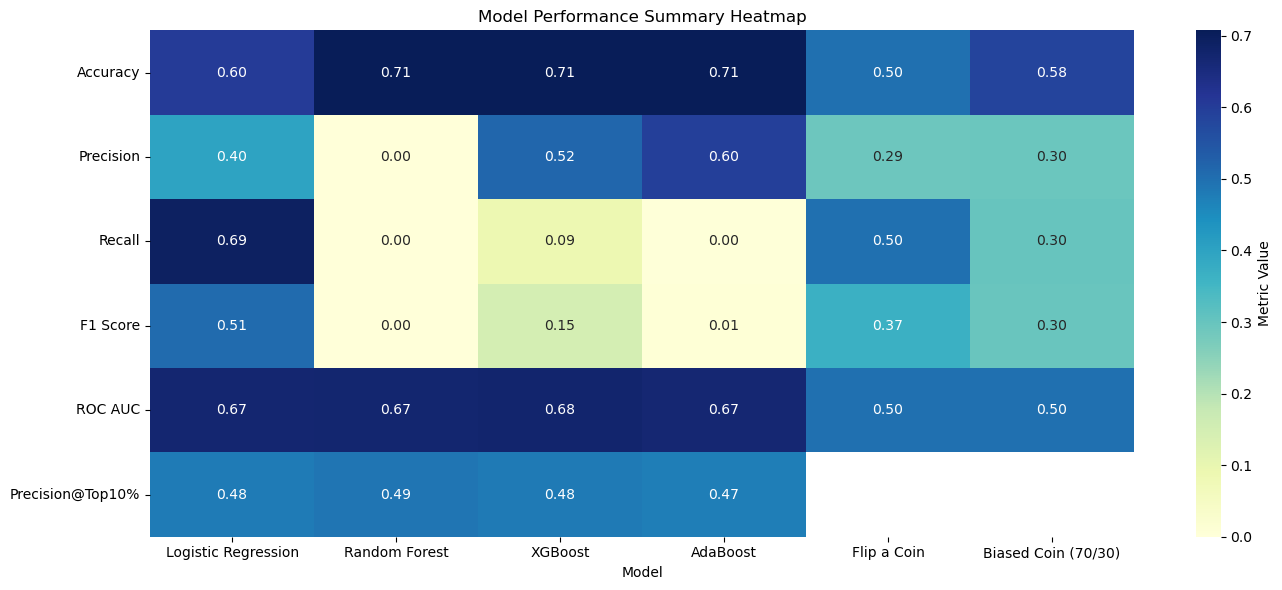

In [115]:
heatmap_metrics = main_metrics # + ['TP', 'FP', 'FN', 'num_Projects_flagged_for_review', 'fraction_Projects_flagged_for_review']

plt.figure(figsize=(14, 6))
sns.heatmap(results_df[heatmap_metrics].T, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Metric Value'})
plt.title("Model Performance Summary Heatmap")
plt.tight_layout()
plt.show()

### Final Metrics Summary Table

In [117]:
pd.set_option("display.precision", 3)

# order columns for readability
ordered_cols = [
    'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Precision@Top10%',
    'TP', 'FP', 'FN', 'TN',
    'num_Projects_flagged_for_review', 'fraction_Projects_flagged_for_review'
]

display(results_df[ordered_cols])

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Precision@Top10%,TP,FP,FN,TN,num_Projects_flagged_for_review,fraction_Projects_flagged_for_review
Model,,,,,,,,,,,,
Logistic Regression,0.603,0.399,0.693,0.506,0.670,0.479,24747,37312,10981,48469,12151,0.100
Random Forest,0.706,0.000,0.000,0.000,0.672,0.491,0,0,35728,85781,12143,0.100
XGBoost,0.708,0.516,0.086,0.147,0.675,0.483,3071,2880,32657,82901,11986,0.099
AdaBoost,0.706,0.596,0.003,0.007,0.668,0.473,124,84,35604,85697,11890,0.098
Flip a Coin,0.498,0.292,0.499,0.369,0.500,NaN,17812,43093,17916,42688,0,0.000
Biased Coin (70/30),0.584,0.296,0.301,0.298,0.500,NaN,10755,25628,24973,60153,0,0.000


### Optional Threshold Evaluations (how well do we perfrom when we are X% certain?)

In [ ]:
'''
def evaluate_threshold(y_true, y_proba, threshold=0.5):
    print(f"\nEvaluating at threshold = {threshold:.2f}")
    y_pred = (y_proba >= threshold).astype(int)

    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    auc = roc_auc_score(y_true, y_proba)
    print(f"AUC: {auc:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

for thresh in [1, 0.99, 0.9, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05]:
    evaluate_threshold(y_test, y_proba, threshold=thresh)
'''